In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

queries = ('q11', 'q12', 'q13', 'q21', 'q22', 'q23', 'q31', 'q32', 'q33', 'q34', 'q41', 'q42', 'q43')

In [2]:
results = pd.DataFrame()
for q in queries:
    data_sync = pd.read_csv(f'{q}-performance-sync.log', header=None, names=['execution_time_ms'])
    data_async = pd.read_csv(f'{q}-performance.log', header=None, names=['execution_time_ms'])
    data_fusion = pd.read_csv(f'{q}-performance-fusion.log', header=None, names=['execution_time_ms'])
    data_heavydb_transformed = pd.read_csv(f'heavydb_perf/transformed/{q}.txt', header=None, names=['execution_time_ms'])
    data_heavydb_original = pd.read_csv(f'heavydb_perf/original/{q}.txt', header=None, names=['execution_time_ms'])
    results[f'{q}_sync'] = data_sync['execution_time_ms']
    results[f'{q}_async'] = data_async['execution_time_ms']
    results[f'{q}_fusion'] = data_fusion['execution_time_ms']
    results[f'{q}_heavydb_transformed'] = data_heavydb_transformed['execution_time_ms']
    results[f'{q}_heavydb_original'] = data_heavydb_original['execution_time_ms']

results.describe()

,q11_sync,q11_async,q11_fusion,q11_heavydb_transformed,q11_heavydb_original,q12_sync,q12_async,q12_fusion,q12_heavydb_transformed,q12_heavydb_original,...,q42_sync,q42_async,q42_fusion,q42_heavydb_transformed,q42_heavydb_original,q43_sync,q43_async,q43_fusion,q43_heavydb_transformed,q43_heavydb_original
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,13.066991,12.740236,13.988446,18.020000,14.590000,14.023130,13.684812,15.929799,15.980000,16.040000,...,16.503086,15.135067,16.819900,52.390000,50.470000,14.213607,12.481374,15.053533,54.940000,66.120000
std,0.058390,0.184307,12.849264,5.508451,4.114755,0.072740,0.175961,17.059742,13.041488,14.127071,...,1.104309,0.774422,10.022558,16.095608,14.940593,1.048972,0.903446,9.871079,85.361006,82.694189
min,13.007900,12.659700,8.117700,11.000000,11.000000,13.943600,13.607900,8.373640,11.000000,10.000000,...,14.834000,13.981400,12.781700,44.000000,45.000000,12.864300,11.603900,9.931090,41.000000,52.000000
25%,13.040025,12.678350,8.605775,13.750000,12.000000,13.989675,13.630175,8.853302,12.000000,12.000000,...,15.571700,14.214975,12.897900,45.000000,45.000000,13.154550,11.771575,11.486375,43.000000,53.000000
50%,13.056750,12.687000,8.764440,17.500000,13.000000,14.008150,13.637250,9.066595,13.000000,13.000000,...,16.354650,15.414100,13.891500,53.000000,46.000000,14.339450,12.058800,12.384700,46.000000,57.000000
75%,13.074275,12.704500,8.957413,21.000000,17.000000,14.038375,13.646550,11.658475,18.000000,18.000000,...,17.344150,15.527150,14.943125,55.000000,53.000000,14.808900,13.134150,12.933650,51.000000,62.000000
max,13.519900,14.070100,67.230100,43.000000,44.000000,14.484600,15.004200,94.462900,141.000000,152.000000,...,19.253400,17.511300,52.929700,204.000000,191.000000,17.193600,15.427900,51.903100,899.000000,883.000000


note on the above: fusion std also takes in consideration when the JIT if the fusion happens, which has way higher execution times. When making plots, we filter out those cases.

In [3]:
comparison = []

for q in queries:
    sync_avg = results[f'{q}_sync'].mean()
    async_avg = results[f'{q}_async'].mean()
    fusion_avg = results[results[f'{q}_fusion'] < 20.0][f'{q}_fusion'].mean()
    heavydb_transformed_avg = results[1:][f'{q}_heavydb_transformed'].mean()
    heavydb_original_avg = results[1:][f'{q}_heavydb_original'].mean()
    speedup_async = (sync_avg - async_avg) / sync_avg
    speedup_fusion = (sync_avg - fusion_avg) / sync_avg
    fusion_async = (async_avg - fusion_avg) / async_avg
    heavydb_original_async = (async_avg - heavydb_original_avg) / async_avg
    heavydb_transformed_async = (async_avg - heavydb_transformed_avg) / async_avg
    # print(f'{q}: Sync avg = {sync_avg:5.2f} ms, Async avg = {async_avg:5.2f} ms, Fusion avg = {fusion_avg:5.2f} ms, Speedup async on sync = {speedup_async:6.2%}, Speedup fusion on sync = {speedup_fusion:6.2%}')

    comparison.append({
        'query': q,
        'sync_avg': sync_avg,
        'async_avg': async_avg,
        'fusion_avg': fusion_avg,
        'heavydb_transformed_avg': heavydb_transformed_avg,
        'heavydb_original_avg': heavydb_original_avg,
        'async_sync': speedup_async * 100,
        'fusion_sync': speedup_fusion * 100,
        'fusion_async': fusion_async * 100,
        'heavydb_original_async': heavydb_original_async * 100,
        'heavydb_transformed_async': heavydb_transformed_async * 100,
    })

comparison = pd.DataFrame(comparison)
# comparison.set_index('query', inplace=True)
comparison

,query,sync_avg,async_avg,fusion_avg,heavydb_transformed_avg,heavydb_original_avg,async_sync,fusion_sync,fusion_async,heavydb_original_async,heavydb_transformed_async
0,q11,13.066991,12.740236,8.739595,17.767677,14.292929,2.500614,33.117005,31.401624,-12.187320,-39.461127
1,q12,14.023130,13.684812,9.085047,14.717172,14.666667,2.412571,35.213846,33.612193,-7.174776,-7.543836
2,q13,13.997501,13.627748,8.856918,13.232323,14.525253,2.641564,36.725009,35.008208,-6.585861,2.901615
3,q21,12.816319,12.031894,11.843347,31.010101,29.818182,6.120517,7.591668,1.567063,-147.826168,-157.732498
4,q22,10.199652,9.333765,8.835067,29.919192,31.898990,8.489377,13.378743,5.342950,-241.759071,-220.547931
5,q23,8.615798,7.784594,6.193019,29.545455,28.696970,9.647448,28.120191,20.445181,-268.637989,-279.537529
6,q31,15.705098,14.747863,13.718777,31.313131,27.555556,6.095059,12.647621,6.977867,-86.844396,-112.323177
7,q32,10.701047,9.443966,9.004991,53.353535,51.707071,11.747272,15.849438,4.648203,-447.514391,-464.948430
8,q33,9.606535,8.106762,7.584868,51.151515,49.000000,15.612004,21.044701,6.437760,-504.433667,-530.973426
9,q34,9.371616,7.872036,7.741775,52.707071,51.797980,16.001298,17.391256,1.654738,-557.999775,-569.548133


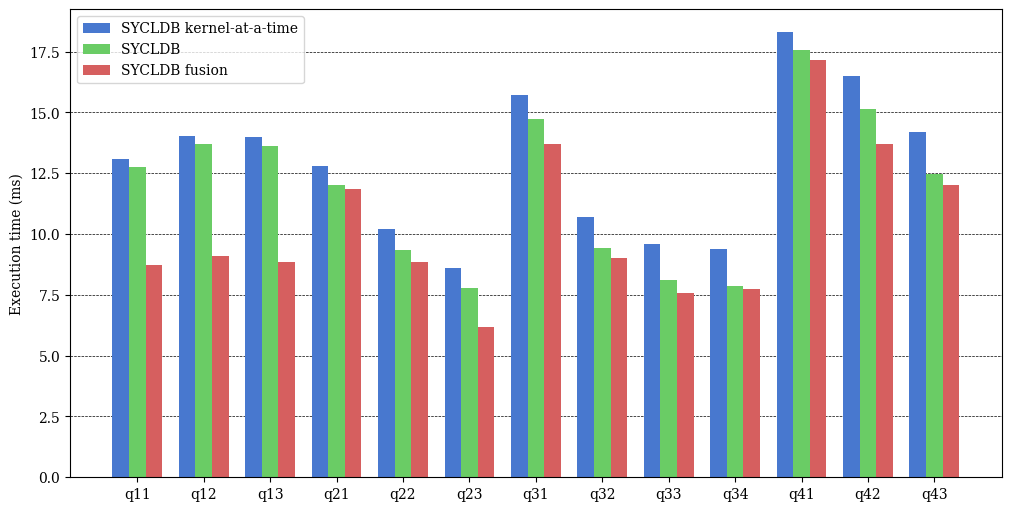

In [4]:
# plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.style.use('seaborn-v0_8-muted')

labels_mapping = {
    # 'heavydb_original_avg': 'HeavyDB',
    'sync_avg': 'SYCLDB kernel-at-a-time',
    'async_avg': 'SYCLDB ',
    'fusion_avg': 'SYCLDB fusion',
}

x = np.arange(len(comparison))
width = 1 / (len(labels_mapping) + 1)
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10, 5))

#iterate on some columns and plot them in a single bar chart
for col, label in labels_mapping.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, comparison[col], width=width, label=label)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.legend()
# ax.set_ylim(0, 60)
ax.set_xticks(x + width, comparison['query'])
ax.set_ylabel('Execution time (ms)')
ax.set_axisbelow(True)
ax.grid(color='black', linestyle='--', linewidth=0.5, zorder=1000, axis='y')

plt.show()

In [5]:
results_cxl = pd.DataFrame()

query_times_crystal = defaultdict(list)

with open('crystal/results.txt') as f:
    for line in f:
        query, time = line.split(': ')
        assert f'q{query}' in queries
        query_times_crystal[f'q{query}'].append(float(time))

for q in queries:
    sync_df = pd.read_csv(f'{q}-performance-sync-cxl.log', header=None, names=['execution_time_ms'])
    async_df = pd.read_csv(f'{q}-performance-async-cxl.log', header=None, names=['execution_time_ms'])
    fusion_df = pd.read_csv(f'{q}-performance-cxl.log', header=None, names=['execution_time_ms'])
    heavydb_df = pd.read_csv(f'heavydb_perf/cxl_server/{q}.txt', header=None, names=['execution_time_ms'])

    results_cxl[f'{q}_sync'] = sync_df['execution_time_ms']
    results_cxl[f'{q}_async'] = async_df['execution_time_ms']
    results_cxl[f'{q}_fusion'] = fusion_df['execution_time_ms']
    results_cxl[f'{q}_crystal'] = query_times_crystal[q]
    results_cxl[f'{q}_heavydb'] = heavydb_df['execution_time_ms']

results_cxl.describe()

,q11_sync,q11_async,q11_fusion,q11_crystal,q11_heavydb,q12_sync,q12_async,q12_fusion,q12_crystal,q12_heavydb,...,q42_sync,q42_async,q42_fusion,q42_crystal,q42_heavydb,q43_sync,q43_async,q43_fusion,q43_crystal,q43_heavydb
count,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,7.336749,6.950151,6.936169,2.561560,59.24000,7.480610,7.138039,5.505814,2.562193,50.850000,...,7.902888,6.899841,16.954277,4.390494,42.810000,6.958989,5.160976,13.780324,4.735919,38.430000
std,0.211763,0.018197,9.421783,0.020717,9.57387,0.037796,0.015252,8.626140,0.016484,30.593581,...,0.174700,0.087539,31.510667,0.040548,30.369674,0.150585,0.104624,27.927838,0.737159,2.871859
min,7.265460,6.908720,5.782120,2.555970,21.00000,7.424670,7.103940,4.419100,2.557220,23.000000,...,7.680380,6.787440,5.824500,4.351780,28.000000,6.833180,4.964030,3.844260,4.566940,28.000000
25%,7.299835,6.940392,5.919897,2.558393,55.00000,7.465530,7.130800,4.566605,2.558985,48.000000,...,7.848635,6.853080,6.016335,4.372357,40.000000,6.899707,5.136178,3.921762,4.623223,38.000000
50%,7.310225,6.947635,5.942235,2.559360,57.50000,7.478720,7.137390,4.596530,2.560420,49.000000,...,7.882550,6.889060,6.788090,4.378145,40.000000,6.934425,5.174730,4.688660,4.636400,39.000000
75%,7.321115,6.957540,5.972383,2.560245,63.00000,7.487570,7.142658,4.601418,2.561707,50.000000,...,7.940772,6.932507,6.805752,4.390867,40.000000,6.964735,5.197740,4.694130,4.656040,39.000000
max,9.391660,7.075760,100.150000,2.765820,93.00000,7.805730,7.239370,90.835300,2.723840,349.000000,...,9.449410,7.576070,128.812000,4.672350,342.000000,8.202850,5.964000,124.056000,11.831500,52.000000


note on the above: fusion std also takes in consideration when the JIT if the fusion happens, which has way higher execution times. When making plots, we filter out those cases.

In [6]:
comparison_cxl = []

for q in queries:
    sync_avg = results_cxl[f'{q}_sync'].mean()
    async_avg = results_cxl[f'{q}_async'].mean()
    fusion_avg = results_cxl[results_cxl[f'{q}_fusion'] < 12.0][f'{q}_fusion'].mean()
    crystal_avg = results_cxl[f'{q}_crystal'].mean()
    heavydb_avg = results_cxl[f'{q}_heavydb'].mean()

    speedup_async = (sync_avg - async_avg) / sync_avg
    speedup_fusion = (sync_avg - fusion_avg) / sync_avg
    fusion_async = (async_avg - fusion_avg) / async_avg

    comparison_cxl.append({
        'query': q,
        'sync_avg': sync_avg,
        'async_avg': async_avg,
        'fusion_avg': fusion_avg,
        'crystal_avg': crystal_avg,
        'heavydb_avg': heavydb_avg,
        'async_sync': speedup_async * 100,
        'fusion_sync': speedup_fusion * 100,
        'fusion_async': fusion_async * 100,
    })

comparison_cxl = pd.DataFrame(comparison_cxl)
comparison_cxl

,query,sync_avg,async_avg,fusion_avg,crystal_avg,heavydb_avg,async_sync,fusion_sync,fusion_async
0,q11,7.336749,6.950151,5.994615,2.561560,59.24,5.269335,18.293305,13.748420
1,q12,7.480610,7.138039,4.643900,2.562193,50.85,4.579461,37.920839,34.941511
2,q13,7.483421,7.108058,4.617890,2.566792,45.58,5.015932,38.291730,35.033031
3,q21,5.611103,3.984008,3.805914,2.830008,37.64,28.997785,32.171732,4.470209
4,q22,4.242118,3.817336,3.019716,2.824962,35.34,10.013446,28.815848,20.894680
5,q23,3.986156,3.468662,3.347773,2.910000,33.87,12.982283,16.014988,3.485159
6,q31,6.089624,5.566903,5.887436,3.424333,36.66,8.583785,3.320192,-5.757832
7,q32,4.540167,3.533796,3.004265,3.301502,70.91,22.165960,33.829205,14.984761
8,q33,4.553606,3.531522,3.063278,3.142639,71.48,22.445587,32.728520,13.258992
9,q34,4.286777,3.005747,2.710467,3.144365,74.49,29.883278,36.771451,9.823866


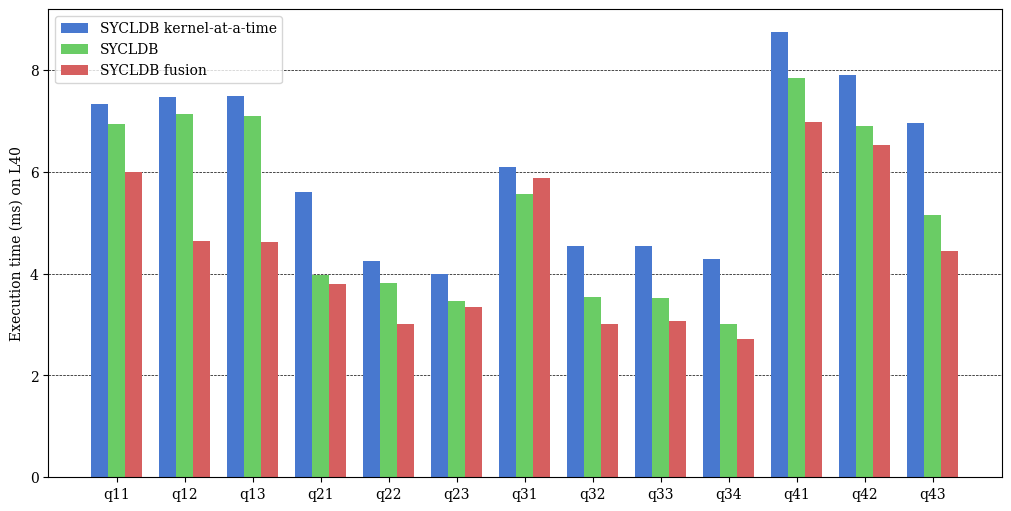

In [ ]:
# plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.style.use('seaborn-v0_8-muted')

labels_mapping = {
    'sync_avg': 'SYCLDB kernel-at-a-time',
    'async_avg': 'SYCLDB',
    'fusion_avg': 'SYCLDB fusion',
    'crystal_avg': 'Crystal',
    'heavydb_avg': 'HeavyDB',
}

x = np.arange(len(comparison_cxl))
width = 1 / (len(labels_mapping) + 1)
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10, 5))

#iterate on some columns and plot them in a single bar chart
for col, label in labels_mapping.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, comparison_cxl[col], width=width, label=label)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.legend()
# ax.set_ylim(0, 60)
ax.set_xticks(x + width, comparison_cxl['query'])
ax.set_ylabel('Execution time (ms) on L40')
ax.set_axisbelow(True)
ax.grid(color='black', linestyle='--', linewidth=0.5, zorder=1000, axis='y')

plt.show()

In [8]:
numa_results = pd.DataFrame()

for q in queries:
    numa0_df = pd.read_csv(f'{q}-performance-cxl-numa-0.log', header=None, names=['execution_time_ms'])
    numa1_df = pd.read_csv(f'{q}-performance-cxl-numa-1.log', header=None, names=['execution_time_ms'])
    numa2_df = pd.read_csv(f'{q}-performance-cxl-numa-2.log', header=None, names=['execution_time_ms'])

    numa_results[f'{q}_gpu_memory'] = results_cxl[f'{q}_async']
    numa_results[f'{q}_numa_0'] = numa0_df['execution_time_ms']
    numa_results[f'{q}_numa_1'] = numa1_df['execution_time_ms']
    numa_results[f'{q}_numa_2'] = numa2_df['execution_time_ms']

numa_results.describe()

,q11_gpu_memory,q11_numa_0,q11_numa_1,q11_numa_2,q12_gpu_memory,q12_numa_0,q12_numa_1,q12_numa_2,q13_gpu_memory,q13_numa_0,...,q41_numa_1,q41_numa_2,q42_gpu_memory,q42_numa_0,q42_numa_1,q42_numa_2,q43_gpu_memory,q43_numa_0,q43_numa_1,q43_numa_2
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,6.950151,318.306590,273.049860,464.140530,7.138039,376.272150,225.244270,444.699620,7.108058,366.738500,...,728.011910,993.724270,6.899841,495.992920,361.613720,632.556150,5.160976,341.358260,299.736290,483.115480
std,0.018197,76.424709,59.610625,14.335661,0.015252,6.382141,7.173372,17.402467,0.017948,32.413827,...,38.292409,12.426582,0.087539,14.684661,24.059826,11.814545,0.104624,13.889173,1.740888,7.069451
min,6.908720,234.079000,232.263000,424.068000,7.103940,366.700000,220.188000,417.533000,7.079930,228.945000,...,711.442000,966.630000,6.787440,363.139000,351.991000,612.644000,4.964030,298.606000,299.031000,469.112000
25%,6.940392,236.069000,234.040000,453.522250,7.130800,370.080500,222.303000,423.001000,7.100548,368.962750,...,715.223250,984.575250,6.853080,492.614250,354.007000,621.372750,5.136178,338.511250,299.171250,477.018250
50%,6.947635,383.992000,236.248500,464.913500,7.137390,373.765500,223.016500,446.310500,7.105935,370.656000,...,716.219500,996.505500,6.889060,494.260000,355.123500,632.004500,5.174730,339.884000,299.345500,483.484000
75%,6.957540,386.875500,352.466500,478.057500,7.142658,382.369750,224.465750,457.029000,7.112785,380.520750,...,718.163500,1001.517500,6.932507,503.577750,358.094500,640.724250,5.197740,353.330500,299.650750,486.433500
max,7.075760,407.071000,395.053000,489.245000,7.239370,390.848000,264.362000,474.223000,7.234380,396.591000,...,893.348000,1013.850000,7.576070,510.012000,489.815000,655.973000,5.964000,358.399000,311.198000,502.132000


In [9]:
comparison_numa = []

for q in queries:
    gpu_memory_avg = numa_results[f'{q}_gpu_memory'].mean()
    numa_0_avg = numa_results[f'{q}_numa_0'].mean()
    numa_1_avg = numa_results[f'{q}_numa_1'].mean()
    numa_2_avg = numa_results[f'{q}_numa_2'].mean()

    comparison_numa.append({
        'query': q,
        'gpu_memory_avg': gpu_memory_avg,
        'numa_0_avg': numa_0_avg,
        'numa_1_avg': numa_1_avg,
        'numa_2_avg': numa_2_avg,
    })

comparison_numa = pd.DataFrame(comparison_numa)
comparison_numa

,query,gpu_memory_avg,numa_0_avg,numa_1_avg,numa_2_avg
0,q11,6.950151,318.30659,273.04986,464.14053
1,q12,7.138039,376.27215,225.24427,444.69962
2,q13,7.108058,366.73850,233.63129,454.54244
3,q21,3.984008,395.52294,415.53723,567.41775
4,q22,3.817336,368.47590,381.30539,515.46220
5,q23,3.468662,272.22182,278.05195,387.48363
6,q31,5.566903,376.45534,416.88774,518.73857
7,q32,3.533796,122.17737,119.25486,169.81803
8,q33,3.531522,104.55027,104.66985,141.01519
9,q34,3.005747,107.54815,104.27973,141.15548


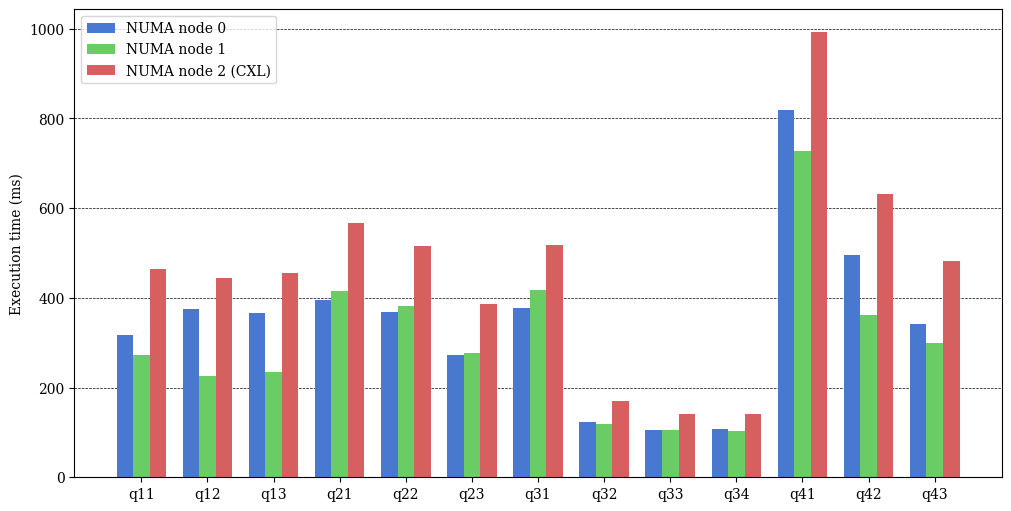

In [10]:
# plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.style.use('seaborn-v0_8-muted')

labels_mapping = {
    # 'gpu_memory_avg': 'SYCLDB GPU',
    'numa_0_avg': 'NUMA node 0',
    'numa_1_avg': 'NUMA node 1',
    'numa_2_avg': 'NUMA node 2 (CXL)',
}

x = np.arange(len(comparison_numa))
width = 1 / (len(labels_mapping) + 1)
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10, 5))

#iterate on some columns and plot them in a single bar chart
for col, label in labels_mapping.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, comparison_numa[col], width=width, label=label)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.legend()
# ax.set_ylim(0, 60)
ax.set_xticks(x + width, comparison_numa['query'])
ax.set_ylabel('Execution time (ms)')
ax.set_axisbelow(True)
ax.grid(color='black', linestyle='--', linewidth=0.5, zorder=1000, axis='y')

plt.show()